## **Fault prediction and classification for the Tennessee Eastman Process (TEP)**

This Jupyter notebook presents a comprehensive exploration of machine learning models aimed at predicting and classifying faults within the Tennessee Eastman Process. The Tennessee Eastman Process is a widely studied chemical process, and fault prediction and classification are critical tasks for ensuring its smooth operation and safety.

The notebook includes:
- Data preprocessing and feature engineering to prepare the dataset for modeling.
- Implementation of machine learning algorithms: random forest for real time prediction and LSTM for classification.
- Evaluation of model performance using relevant metrics like accuracy, precision, recall, and F1-score.
- Fine-tuning of models through hyperparameter optimization to enhance predictive capabilities.
- Visualization of results and insights into the behavior of different models.

This notebook serves as a practical example for engineers, researchers, and practitioners interested in applying machine learning techniques to fault prediction and classification in complex industrial processes like the Tennessee Eastman Process.

The following dependencies must be installed and ran for the proper function of the code base:

In [1]:
import sys
!{sys.executable} -m pip install pandas numpy matplotlib seaborn scikit-learn tensorflow gdown joblib

In [2]:
import pandas as pd
import gdown
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
#from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
#from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Input
from keras.models import Model
from keras.callbacks import EarlyStopping
from keras import backend as K
from keras.layers import Input, Dense, LSTM, Bidirectional, Dropout
from keras.metrics import Precision, Recall
from collections import defaultdict

## Data importing and pre-processing

The relevant data files for the model can be obtained by running the code block below.

In [3]:
# Create a temporary directory to store downloaded files
temp_dir = 'temp_downloads'
if not os.path.exists(temp_dir):
    os.makedirs(temp_dir)

# List of file URLs
file_urls = [
    'https://drive.google.com/file/d/1BxF3tVenKz6jgF-kXH71mYTtpYAD8VPA/view?usp=sharing',
    'https://drive.google.com/file/d/1fdgoJ5ZEuWNUTkY1w6aNhzyYDL7bDbeo/view?usp=sharing',
    'https://drive.google.com/file/d/1nGSmLzCx3Ku2999ZcfRt6L4Fh2m1Aaly/view?usp=sharing',
    'https://drive.google.com/file/d/1x_2gXR0Cnf2AA72q6PUIIipl_XQQMihI/view?usp=sharing'
]

# List of output file names
output_files = [
    'faulty_training.csv',
    'faultfree_training.csv',
    'faulty_testing.csv',
    'faultfree_testing.csv'
]

# Reading each file directly into a DataFrame
dataframes = []
for url, output_file in zip(file_urls, output_files):
    # Downloading the file into the temporary directory
    url_parts = url.split('/')
    file_id = url_parts[-2].split('=')[-1]
    url_direct = f'https://drive.google.com/uc?id={file_id}'
    output_path = os.path.join(temp_dir, output_file)
    gdown.download(url_direct, output_path, quiet=False)

    # Reading the CSV file into a DataFrame
    df = pd.read_csv(output_path, on_bad_lines='skip')

    # Appending the DataFrame to the list
    dataframes.append(df)

# Unpacking the list of DataFrames
faulty_training, faultfree_training, faulty_testing, faultfree_testing = dataframes

# Clean up temporary directory
import shutil
shutil.rmtree(temp_dir)

'''
df = pd.read_csv(r'D:\OneDrive - Alberta Innovates\school\machine learning - 788\final project\TEP_Faulty_Training.csv', on_bad_lines='skip')
df2 = pd.read_csv(r'D:\OneDrive - Alberta Innovates\school\machine learning - 788\final project\TEP_FaultFree_Training.csv', on_bad_lines='skip')
df_test = pd.read_csv(r'D:\OneDrive - Alberta Innovates\school\machine learning - 788\final project\TEP_Faulty_Testing.csv', on_bad_lines='skip')
df2_test = pd.read_csv(r'D:\OneDrive - Alberta Innovates\school\machine learning - 788\final project\TEP_FaultFree_Testing.csv', on_bad_lines='skip')
'''

Downloading...
From (original): https://drive.google.com/uc?id=1BxF3tVenKz6jgF-kXH71mYTtpYAD8VPA
From (redirected): https://drive.google.com/uc?id=1BxF3tVenKz6jgF-kXH71mYTtpYAD8VPA&confirm=t&uuid=663f6306-a52f-46ea-adb9-1185ad54ec8e
To: d:\OneDrive - Alberta Innovates\school\machine learning - 788\final project\MECE788Group1\main\temp_downloads\faulty_training.csv
100%|██████████| 1.87G/1.87G [00:49<00:00, 37.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1fdgoJ5ZEuWNUTkY1w6aNhzyYDL7bDbeo
To: d:\OneDrive - Alberta Innovates\school\machine learning - 788\final project\MECE788Group1\main\temp_downloads\faultfree_training.csv
100%|██████████| 93.6M/93.6M [00:02<00:00, 39.4MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1nGSmLzCx3Ku2999ZcfRt6L4Fh2m1Aaly
From (redirected): https://drive.google.com/uc?id=1nGSmLzCx3Ku2999ZcfRt6L4Fh2m1Aaly&confirm=t&uuid=c8fe079d-f521-4458-aba1-11ef74cc799f
To: d:\OneDrive - Alberta Innovates\school\machine learning - 788\final

"\ndf = pd.read_csv(r'D:\\OneDrive - Alberta Innovates\\school\\machine learning - 788\x0cinal project\\TEP_Faulty_Training.csv', on_bad_lines='skip')\ndf2 = pd.read_csv(r'D:\\OneDrive - Alberta Innovates\\school\\machine learning - 788\x0cinal project\\TEP_FaultFree_Training.csv', on_bad_lines='skip')\ndf_test = pd.read_csv(r'D:\\OneDrive - Alberta Innovates\\school\\machine learning - 788\x0cinal project\\TEP_Faulty_Testing.csv', on_bad_lines='skip')\ndf2_test = pd.read_csv(r'D:\\OneDrive - Alberta Innovates\\school\\machine learning - 788\x0cinal project\\TEP_FaultFree_Testing.csv', on_bad_lines='skip')\n"

In [4]:
f_train = faulty_training.copy()
ff_train = faultfree_training.copy()
f_test = faulty_testing.copy()
ff_test = faultfree_testing.copy()

As faults are introduced every **hour** for the faulty training data set, and every **8 hours** for the faulty testing data set, a faultOccurence variable is added, and the faultNumber labelling is corrected for mislabelled data for the first 20 and 160 points, respectively.

In [6]:
def add_and_set_fault_occurrence(df, num_first, num_last=None):
    '''
    Add and set the 'faultOccurrence' column for binary classification.

    Parameters:
    - df: DataFrame containing fault data.
    - num_first: Number of initial rows to label as non-faulty.
    - num_last: Number of final rows to label as faulty (default=None, all rows are labeled as non-faulty).

    Returns:
    - DataFrame with 'faultOccurrence' column added and values set for binary classification.
    '''
    
    # Check if 'faultOccurrence' column already exists
    if 'faultOccurrence' not in df.columns:
        # Inserting the 'faultOccurrence' column filled with NaN initially to the right of 'faultNumber'
        fault_number_index = df.columns.get_loc('faultNumber')
        df.insert(fault_number_index + 1, 'faultOccurrence', pd.NA)

    # Function to set values based on the condition
    def set_fault_occurrence(group):
        if num_last is not None:
            group.iloc[:num_first, df.columns.get_loc('faultOccurrence')] = 0
            group.iloc[-num_last:, df.columns.get_loc('faultOccurrence')] = 1
        else:
            group.iloc[:, df.columns.get_loc('faultOccurrence')] = 0
        return group

    # Applying the function to each group
    df = df.groupby(df.index // (num_first + (num_last or 0))).apply(set_fault_occurrence)
    df['faultOccurrence'] = df['faultOccurrence'].astype(int)
    df.reset_index(drop=True, inplace=True)

    return df

# Add the faultOccurence column for binary classification
f_train = add_and_set_fault_occurrence(f_train, 20, 480)
f_test = add_and_set_fault_occurrence(f_test, 160, 800)
ff_train = add_and_set_fault_occurrence(ff_train, len(ff_train))
ff_test = add_and_set_fault_occurrence(ff_test, len(ff_test))

# Set faultNumber to 0 for rows where faultOccurence is 0 (no fault)
f_train.loc[f_train['faultOccurrence'] == 0, 'faultNumber'] = 0
f_test.loc[f_test['faultOccurrence'] == 0, 'faultNumber'] = 0
ff_train.loc[ff_train['faultOccurrence'] == 0, 'faultNumber'] = 0
ff_test.loc[ff_test['faultOccurrence'] == 0, 'faultNumber'] = 0

print("Shape of f_train:", f_train.shape)
print("Shape of f_test:", f_test.shape)
print("Shape of ff_train:", ff_train.shape)
print("Shape of ff_test:", ff_test.shape)

Shape of f_train: (5000000, 56)
Shape of f_test: (9600000, 56)
Shape of ff_train: (250000, 56)
Shape of ff_test: (480000, 56)


As part of the data pre-processing stage, for binary classification (using Random Forest), a stitched data set for training is generated using statistical properties of the fault free data sets provided to form the test set. The training set with faults (f_train) is used for the generation of the "stitched" data set.

In [7]:
# The entire fault free data set is used
faultfree = pd.concat([ff_train, ff_test])
avg = faultfree.mean()
std = faultfree.std()

# Define the number of points to take from each set
points_per_set = 480
total_points = 500

# Initialize an empty list to store the dataframes for the last 480 points from each set
last_480_points_dfs = []

# Calculate the number of sets based on the total number of points and the points per set
num_sets = len(f_train) // total_points

# Iterate over each set
for i in range(num_sets):
    # Calculate the starting index of the set
    start_index = (i * total_points) + 20  # Skip the first 20 points
    # Take the last 480 points from the current set
    last_480_points_df = f_train.iloc[start_index + total_points - points_per_set:start_index + total_points]
    # Append the dataframe to the list
    last_480_points_dfs.append(last_480_points_df)

# Concatenate the dataframes in the list to create the new dataframe
last480points_df = pd.concat(last_480_points_dfs, ignore_index=True)

# Shuffle the order of the chunks
num_chunks = len(last480points_df) // points_per_set
chunk_indices = np.random.permutation(num_chunks)

# Reconstruct the DataFrame with shuffled chunks
shuffled_indices = np.concatenate([np.arange(i * points_per_set, (i + 1) * points_per_set) for i in chunk_indices])
shuffled_df = last480points_df.iloc[shuffled_indices]

def generate_synthetic_rows(avg_values, std_values, min_rows=1, max_rows=1001, multiple_of_20=True):
    if multiple_of_20:
        min_rows = (min_rows // 20) * 20
        max_rows = (max_rows // 20) * 20
    num_rows = np.random.randint(min_rows // 20, max_rows // 20 + 1) * 20  # Generate random multiple of 20
    synthetic_rows = pd.DataFrame({col: np.random.normal(avg_values[col], std_values[col], size=num_rows) for col in avg_values.index})
    synthetic_rows['faultNumber'] = 0  # Set faultNumber as 0
    synthetic_rows['faultOccurrence'] = 0  # Set faultOccurrence as 0
    return synthetic_rows

# Initialize empty list to store reconstructed last 480 rows dataframes
reconstructed_last_480_dfs = []

# Iterate over each set
for i in range(num_sets):
    # Calculate the starting index of the set
    start_index = i * total_points

    # Generate synthetic rows for the beginning and end
    total_synthetic_rows = np.random.randint(0, 26) * 20  # Generate random multiple of 20 between 0 and 500 for total rows

    # Ensure min_rows and max_rows are multiples of 20
    min_rows = max_rows = total_synthetic_rows

    # Adjust the number of synthetic rows to be a multiple of 20
    total_synthetic_rows = (total_synthetic_rows // 20) * 20

    # Generate synthetic rows for the beginning and end
    synthetic_rows_start = generate_synthetic_rows(avg, std, min_rows=min_rows, max_rows=max_rows)
    synthetic_rows_end = generate_synthetic_rows(avg, std, min_rows=min_rows, max_rows=max_rows)

    # Trim synthetic rows if necessary
    synthetic_rows_start = synthetic_rows_start[:total_synthetic_rows // 2]
    synthetic_rows_end = synthetic_rows_end[:total_synthetic_rows // 2]
    
    # Extract chunk for this set from the shuffled dataset
    set_chunk = shuffled_df.iloc[i * points_per_set: (i + 1) * points_per_set].copy()
    
    # Concatenate synthetic rows with the chunks
    reconstructed_last_480_df = pd.concat([synthetic_rows_start, set_chunk, synthetic_rows_end], ignore_index=True)
    
    # Add faultOccurrence column
    reconstructed_last_480_df['faultOccurrence'] = reconstructed_last_480_df['faultNumber'].apply(lambda x: 0 if x == 0 else 1)
    
    # Reorder columns to ensure faultNumber and faultOccurrence are on the left side
    cols = ['faultNumber', 'faultOccurrence'] + [col for col in reconstructed_last_480_df.columns if col not in ['faultNumber', 'faultOccurrence']]
    reconstructed_last_480_df = reconstructed_last_480_df[cols]
    
    # Append reconstructed dataframe to list
    reconstructed_last_480_dfs.append(reconstructed_last_480_df)

# Concatenate all reconstructed last 480 rows dataframes and modify simulationRun and sample columns to synthetic values
reconstructed_last_480_full_df = pd.concat(reconstructed_last_480_dfs, ignore_index=True)
reconstructed_last_480_full_df['simulationRun'] = 1
reconstructed_last_480_full_df['sample'] = reconstructed_last_480_full_df.index + 1

# Remove simulationRun and sample columns
reconstructed_df = reconstructed_last_480_full_df.copy()

Some quick checks are carried out the confirm the correct nature of the stitched data set. The simulationRun and sample columns are meaningless for this data set and will be removed when integrated into the model pipeline.

In [8]:
reconstructed_df.head(250)

,faultNumber,faultOccurrence,simulationRun,sample,xmeas_1,xmeas_2,xmeas_3,xmeas_4,xmeas_5,xmeas_6,...,xmv_2,xmv_3,xmv_4,xmv_5,xmv_6,xmv_7,xmv_8,xmv_9,xmv_10,xmv_11
0,4,1,1,1,0.22085,3706.1,4495.6,9.3138,27.106,42.507,...,54.294,21.698,59.983,22.167,39.000,41.242,46.690,48.554,45.270,18.983
1,4,1,1,2,0.22114,3737.4,4554.7,9.2773,27.269,42.620,...,53.587,21.669,61.787,22.232,39.028,33.702,42.931,48.556,45.027,16.135
2,4,1,1,3,0.24420,3742.9,4531.1,9.2900,26.815,42.748,...,54.290,23.981,61.064,22.013,40.368,39.361,49.202,48.717,45.795,16.440
3,4,1,1,4,0.24310,3761.2,4516.0,9.2921,27.026,42.202,...,54.470,24.089,62.499,21.840,40.712,35.084,46.389,48.773,44.926,17.177
4,4,1,1,5,0.26216,3675.0,4531.7,9.3989,26.495,42.505,...,54.343,25.676,60.447,21.777,40.383,37.909,44.590,48.964,44.746,19.043
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,4,1,1,246,0.23860,3679.7,4549.8,9.2209,26.756,42.361,...,54.461,23.999,62.674,21.850,37.629,37.088,44.498,44.391,44.738,15.776
246,4,1,1,247,0.25803,3604.1,4521.8,9.3811,26.960,42.335,...,53.835,25.439,60.827,21.886,40.202,35.574,47.132,44.445,44.503,16.135
247,4,1,1,248,0.25571,3644.1,4550.1,9.2331,26.701,42.475,...,53.495,25.667,61.301,21.611,39.907,38.289,50.530,44.197,44.616,18.732
248,4,1,1,249,0.24597,3646.8,4511.0,9.2984,27.287,42.137,...,54.503,24.074,61.974,22.086,42.647,37.250,46.283,44.246,45.172,18.130


In [9]:
print(reconstructed_df['faultNumber'].unique())
print(reconstructed_df['faultOccurrence'].unique())
print(reconstructed_df.shape)

[ 4  0 14 19  2  8 16 18 12  3  5 10  1 15  6 11  7 20  9 17 13]
[1 0]
(7322880, 56)


An example of plot of xmeas_1 for the reconstructed, stitched data is shown below. Synthetic data (no fault) is clearly within the baseline as with the provided data sets.

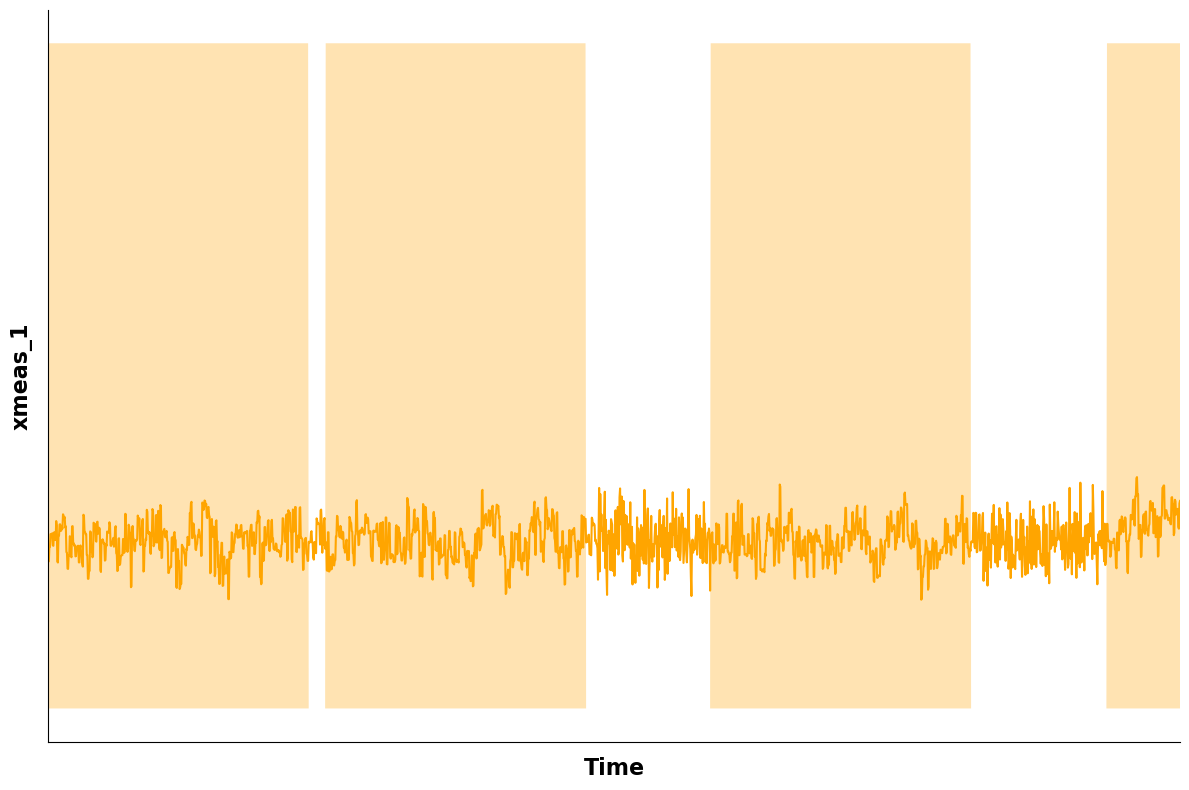

In [10]:
# Create a figure with one subplot
fig, ax1 = plt.subplots(figsize=(12, 8))

# Plot xmeas_1 vs. index for the first 2000 points
ax1.plot(reconstructed_df.index[:2000], reconstructed_df['xmeas_1'][:2000], linestyle='-', color='orange', label='xmeas_1')
ax1.set_xlabel('Time', fontsize=16, fontweight='bold')
ax1.set_ylabel('xmeas_1', fontsize=16, fontweight='bold')
ax1.tick_params(axis='y', labelcolor='red')
ax1.set_yticklabels([])
ax1.set_xticklabels([])
#ax1.set_ylim(0, 0.5)
ax1.spines['top'].set_color('none')
ax1.spines['right'].set_color('none')
ax1.tick_params(axis='x', which='both', bottom=False, top=False)
ax1.tick_params(axis='y', which='both', left=False, right=False)
ax1.set_xlim(reconstructed_df.index[0], reconstructed_df.index[2000-1])

# Add shaded background for fault occurrences
fault_occurrences = reconstructed_df['faultOccurrence'][:2000]
ax1.fill_between(reconstructed_df.index[:2000], 0, fault_occurrences, color='orange', alpha=0.3, label='Fault Occurrence', edgecolor='none')

plt.tight_layout()
plt.show()

## Binary Classification (Fault/no-Fault), Random Forest

The pipeline for the Random Forest model involves creating lag features with four different lags, as well as applying a  Fast Fourier Transform (FFT).

In [11]:
features_to_drop = ['xmeas_2', 'xmeas_5', 'xmeas_12', 'xmeas_14', 'xmeas_15', 'xmeas_17', 'xmeas_37', 'xmv_7', 'xmv_8']

def featureengg(df, features_to_drop):
    # Drop the specified features from the dataframe and create a copy
    clean_df = df.drop(columns=features_to_drop).copy()

    # Define window size for rolling statistics and lag intervals for lagged features
    window_size = 20
    lag_intervals = [2, 4, 6, 8]

    # Initialize dictionary to store new columns
    new_columns = defaultdict(list)

    # Iterate over unique fault numbers in the dataframe
    for fault in clean_df['faultNumber'].unique():
        # Iterate over unique simulation runs for each fault
        for run in clean_df[clean_df['faultNumber'] == fault]['simulationRun'].unique():
            # Mask to filter dataframe for current fault and simulation run
            mask = (clean_df['faultNumber'] == fault) & (clean_df['simulationRun'] == run)

            # Calculate rolling mean, rolling standard deviation, and FFT maximum for each feature
            for feature in clean_df.columns.difference(['faultNumber', 'simulationRun', 'sample']):
                ma = clean_df.loc[mask, feature].rolling(window=window_size, min_periods=1).mean()
                std = clean_df.loc[mask, feature].rolling(window=window_size, min_periods=1).std()
                fft_max = clean_df.loc[mask, feature].rolling(window=window_size).apply(lambda x: np.abs(np.fft.fft(x)[-1]), raw=True)

                # Store the calculated statistics as new columns with appropriate names
                new_columns[f'{feature}_MA'].extend(ma)
                new_columns[f'{feature}_STD'].extend(std)
                new_columns[f'{feature}_FFT_Max'].extend(fft_max)

                # Generate lagged features for specified lag intervals
                for lag in lag_intervals:
                    lag_name = f'{feature}_lag{lag}'
                    lagged = clean_df.loc[mask, feature].shift(lag)
                    new_columns[lag_name].extend(lagged)

    # Create a new dataframe from the generated new columns
    new_columns_df = pd.DataFrame(new_columns, index=clean_df.index)
    # Concatenate the new dataframe with the original dataframe
    clean_df = pd.concat([clean_df, new_columns_df], axis=1)

    return clean_df

In [13]:
#Sub-sample (20)
f_train = f_train.loc[(f_train['simulationRun']<61),:]
#ff_train = ff_train.loc[(ff_train['simulationRun']<41),:]

f_test = f_test.loc[(f_test['simulationRun']<41),:]
ff_test = ff_test.loc[(ff_test['simulationRun']<41),:]

#subsampled_df = reconstructed_df.iloc[:2000000]
tr, ts = train_test_split(reconstructed_df, test_size=0.2, shuffle=False, random_state=42)

#Combine Test data
#combined_df_test = pd.concat([f_test, ff_test], ignore_index=True)
#combined_df_test = f_test

#Combine Training data
#combined_df = pd.concat([f_train], ignore_index=True)

In [53]:
# Feature engineering on the training data set
rf_train = featureengg(tr, features_to_drop)
rf_train.dropna(axis=0, inplace=True)
X_rf_train = rf_train.drop(columns=['faultNumber','simulationRun','sample','faultOccurrence'])
Y_rf_train = rf_train['faultOccurrence']

In [81]:
# Feature engineering on the testing data set
rf_test = featureengg(ts, features_to_drop)
rf_test.dropna(axis=0, inplace=True)
X_rf_test = rf_test.drop(columns=['faultNumber','simulationRun','sample','faultOccurrence'])
Y_rf_test = rf_test['faultOccurrence']

In [89]:
# Define the initial transformer pipeline
initial_transformer = Pipeline([
    ('scaler', StandardScaler(with_mean=False))
])

# Define the classifier
classifier = RandomForestClassifier(n_estimators=200, max_depth=40)

# Create the full pipeline with initial transformation and classifier
full_pipeline = Pipeline([
    ('initial_transform', initial_transformer),
    ('classifier', classifier)
])

RF_model = full_pipeline.fit(X_rf_train, Y_rf_train)

In [90]:
#USE ONLY FOR SAVING MODEL FILE
model_pkl_file = "rf_model_60.pkl"  

with open(model_pkl_file, 'wb') as file:  
    pickle.dump(RF_model, file)

In [99]:
#USE ONLY FOR IMPORTING MODEL FILE
model_pkl_file = "rf_model_conc_test.pkl" 

# load model from pickle file
with open(model_pkl_file, 'rb') as file:  
    RF_model = pickle.load(file)

The pipeline is now ready to use for generating predictions for the Random Forest model. A classification report of the test data is generated which shows accuracy of predictions. The predicted true fault values are used as the test input of the LSTM model in the following sections.

In [100]:
predictions = RF_model.predict(X_rf_test)
results_df = pd.DataFrame({
    'Actual': Y_rf_test,
    'Predicted': predictions,
    'Correct': Y_rf_test == predictions,
})

# Extracting the correctly predicted fault values
results_df['sample'] = rf_test['sample']
#results_df['simulationRun'] = rf_test['simulationRun']

In [101]:
results_df.head(250)

,Actual,Predicted,Correct,sample
19,0,1,False,20
20,0,1,False,21
21,0,1,False,22
22,0,1,False,23
23,0,1,False,24
...,...,...,...,...
264,1,1,True,265
265,1,1,True,266
266,1,1,True,267
267,1,1,True,268


In [102]:
results_df['Correct'] = results_df['Actual'] == results_df['Predicted']

classification_rep = classification_report(results_df['Actual'], results_df['Predicted'])

# Print the classification report
print(classification_rep)


              precision    recall  f1-score   support

           0       0.62      0.07      0.13    740230
           1       0.64      0.97      0.77   1259371

    accuracy                           0.64   1999601
   macro avg       0.63      0.52      0.45   1999601
weighted avg       0.63      0.64      0.54   1999601



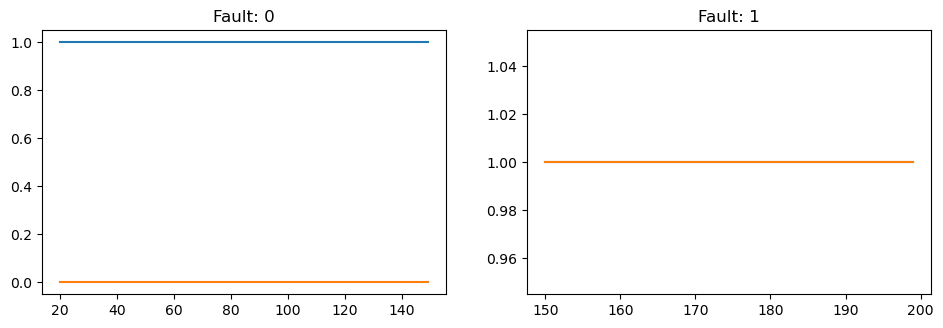

In [20]:
#Results for multi classification
results_ratio_dict = {}
plt.figure(figsize=(24, 24))
for fault in results_df['Actual'].unique():
    plt.subplot(6,4,fault+1)
    one_one = results_df.loc[(results_df['Actual']==fault) & (results_df['sample']<200)].groupby(['sample']).count()
    plt.plot(one_one['Actual'])
    tne_one = results_df.loc[(results_df['Actual']==fault) & (results_df['sample']<200)].groupby(['sample']).sum()
    plt.plot(tne_one['Correct'])
    plt.title(f'Fault: {fault}')
    sums = results_df.loc[results_df['Actual'] == fault].groupby('sample')['Correct'].sum()
    
    # Count the occurrences of each 'Sample' within the current fault
    counts = results_df.loc[results_df['Actual'] == fault].groupby('sample').size()
    
    # Calculate the ratio (sum/count) and store it in the dictionary
    ratio = sums / counts
    results_ratio_dict[f'{fault}_ratio'] = ratio

# Convert the dictionary into a DataFrame
results_ratio_df = pd.DataFrame(results_ratio_dict)

In [ ]:

# Compute confusion matrix based on 'Actual' and 'Predicted' values
conf_matrix = confusion_matrix(results_df['Actual'], results_df['Predicted'])

# Visualize confusion matrix using a heatmap
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False)

# Compute precision, recall, and F1-score using weighted averaging
precision, recall, f1, _ = precision_recall_fscore_support(results_df['Actual'], results_df['Predicted'], average='weighted')
print(f"Precision: {precision}\nRecall: {recall}\nF1-Score: {f1}")

# Calculate and print accuracy
accuracy = accuracy_score(results_df['Actual'], results_df['Predicted'])
print(f"Accuracy: {accuracy}")

# Group samples with sample number greater than 160 by 'Actual' values and compute accuracy for each group
anotherone = results_df.loc[results_df['sample'] > 160].groupby(['Actual']).agg({'Predicted': 'count', 'Correct': 'sum'})
anotherone['accuracy'] = anotherone['Correct'] / anotherone['Predicted']

# Display the first 20 rows of results_df
results_df.head(20)

## Multiclassification (LSTM)

The second part of the challenge to accurately predict and classify faults in the TEP process is to classify the **type** of fault (which was previously correctly predicted by the Random Forest model) occuring. There are 20 faults possible - more details are available in the EDA file.

The first step is to re-trace the predicted rows to the original data frame and extra those values to use as the test set for the LSTM model.

In [31]:
filtered_results_df = results_df.copy()
predicted_value_1_rows = results_df.loc[results_df['Predicted'] == 1]
filtered_results_df.loc[predicted_value_1_rows.index, 'sample'] = predicted_value_1_rows['sample']
sample_numbers = filtered_results_df['sample']
extracted_rows = reconstructed_df[reconstructed_df['sample'].isin(sample_numbers)]
extracted_rows.head(750)

,faultNumber,faultOccurrence,simulationRun,sample,xmeas_1,xmeas_2,xmeas_3,xmeas_4,xmeas_5,xmeas_6,...,xmv_2,xmv_3,xmv_4,xmv_5,xmv_6,xmv_7,xmv_8,xmv_9,xmv_10,xmv_11
19,0,0,1,20,0.275433,3651.292088,4536.689866,9.382920,27.051088,42.446406,...,53.914482,25.196848,60.523860,22.274239,38.433880,37.872587,46.720347,48.930860,41.330645,18.530281
20,0,0,1,21,0.266413,3635.140598,4443.169578,9.451940,26.956530,42.253554,...,53.770240,22.723456,61.708070,22.275271,41.210462,42.679434,48.698867,41.597626,39.755563,18.168610
21,0,0,1,22,0.249114,3642.414229,4575.095511,9.206984,26.984207,42.473554,...,53.323761,23.392332,62.516219,22.340959,40.189534,41.891900,44.971252,49.510203,40.575929,19.165698
22,0,0,1,23,0.255634,3621.343670,4506.014198,9.173548,26.833978,42.186660,...,54.365707,24.963432,63.334066,22.626828,40.142634,41.557323,47.490440,47.876794,41.450574,17.560256
23,0,0,1,24,0.222378,3703.807705,4509.778334,9.290046,26.840088,42.405839,...,54.500833,25.446577,60.248859,22.718094,39.522551,33.286715,44.530194,45.652090,40.146608,18.739346
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
764,0,0,1,765,0.228423,3612.089121,4508.188274,9.501624,26.922493,42.238807,...,54.726075,24.206894,61.961885,22.317784,40.505484,35.626743,42.622854,44.950170,40.069602,19.059434
765,0,0,1,766,0.275863,3720.501379,4559.149079,9.390397,27.162578,42.099222,...,53.384554,22.311420,62.254231,22.692129,40.362724,35.081347,45.084399,54.857660,41.919554,18.318454
766,0,0,1,767,0.293400,3669.543399,4546.037540,9.322329,27.226914,42.337731,...,53.576204,23.442266,60.835105,22.263809,41.513738,41.143312,47.373531,47.155703,41.944839,18.626227
767,16,1,1,768,0.255150,3665.200000,4505.300000,9.267900,26.714000,42.281000,...,53.576000,25.494000,61.261000,21.253000,40.415000,44.146000,50.025000,45.111000,41.132000,17.753000


In [32]:
# Get the index from filtered_results_df
#filtered_index = filtered_results_df.index

# Filter using the index
#lstm_test = f_test.loc[filtered_index]
#lstm_test = lstm_test.drop(columns=['faultOccurrence', 'simulationRun','sample'])
lstm_test = extracted_rows.drop(columns=['faultOccurrence', 'simulationRun','sample'])

lstm_test.head()

,faultNumber,xmeas_1,xmeas_2,xmeas_3,xmeas_4,xmeas_5,xmeas_6,xmeas_7,xmeas_8,xmeas_9,...,xmv_2,xmv_3,xmv_4,xmv_5,xmv_6,xmv_7,xmv_8,xmv_9,xmv_10,xmv_11
19,0,0.275433,3651.292088,4536.689866,9.382920,27.051088,42.446406,2708.470317,75.319240,120.420119,...,53.914482,25.196848,60.523860,22.274239,38.433880,37.872587,46.720347,48.930860,41.330645,18.530281
20,0,0.266413,3635.140598,4443.169578,9.451940,26.956530,42.253554,2716.243353,75.071937,120.420129,...,53.770240,22.723456,61.708070,22.275271,41.210462,42.679434,48.698867,41.597626,39.755563,18.168610
21,0,0.249114,3642.414229,4575.095511,9.206984,26.984207,42.473554,2714.916781,74.960635,120.390987,...,53.323761,23.392332,62.516219,22.340959,40.189534,41.891900,44.971252,49.510203,40.575929,19.165698
22,0,0.255634,3621.343670,4506.014198,9.173548,26.833978,42.186660,2716.119004,75.196665,120.345541,...,54.365707,24.963432,63.334066,22.626828,40.142634,41.557323,47.490440,47.876794,41.450574,17.560256
23,0,0.222378,3703.807705,4509.778334,9.290046,26.840088,42.405839,2706.742001,75.424130,120.365585,...,54.500833,25.446577,60.248859,22.718094,39.522551,33.286715,44.530194,45.652090,40.146608,18.739346


Next, the original data frames are used for splitting into necessary train and cross validation sets for the LSTM model. Sliding window is incorporated as a necessary technique for proper function of the LSTM model.

In [33]:
# Splitting the dataset into train, cross-validation and test sets
lstm_train = f_train.drop(columns=['faultOccurrence', 'simulationRun','sample'])
train, cv = train_test_split(lstm_train, test_size=0.2, shuffle=False, random_state=42)
test = lstm_test

train.head()

,faultNumber,xmeas_1,xmeas_2,xmeas_3,xmeas_4,xmeas_5,xmeas_6,xmeas_7,xmeas_8,xmeas_9,...,xmv_2,xmv_3,xmv_4,xmv_5,xmv_6,xmv_7,xmv_8,xmv_9,xmv_10,xmv_11
0,0,0.25038,3674.0,4529.0,9.2320,26.889,42.402,2704.3,74.863,120.41,...,53.744,24.657,62.544,22.137,39.935,42.323,47.757,47.510,41.258,18.447
1,0,0.25109,3659.4,4556.6,9.4264,26.721,42.576,2705.0,75.000,120.41,...,53.414,24.588,59.259,22.084,40.176,38.554,43.692,47.427,41.359,17.194
2,0,0.25038,3660.3,4477.8,9.4426,26.875,42.070,2706.2,74.771,120.42,...,54.357,24.666,61.275,22.380,40.244,38.990,46.699,47.468,41.199,20.530
3,0,0.24977,3661.3,4512.1,9.4776,26.758,42.063,2707.2,75.224,120.39,...,53.946,24.725,59.856,22.277,40.257,38.072,47.541,47.658,41.643,18.089
4,0,0.29405,3679.0,4497.0,9.3381,26.889,42.650,2705.1,75.388,120.39,...,53.658,28.797,60.717,21.947,39.144,41.955,47.645,47.346,41.507,18.461


In [35]:
def SlidingWindow(df, w, s):
    X = []
    Y = []
    
    # Find the index of the first column (target variable)
    target_index = 0
    
    for i in range(0, len(df)-w+1, s):
        # Selecting features from the columns after the first column
        x = np.array(df.iloc[i:i+w, 1:])  # Exclude the first column
        
        # Selecting the target value from the first column
        y = df.iloc[i, target_index] 
        
        X.append(x)
        Y.append(y)
        
    X = np.array(X)
    Y = np.array(Y)
    
    return X, Y

def process_data(train, test, cv, SlidingWindow):
    # Initialize window size and step size
    w = 20
    s = 20

    # Initialize lists for storing the data
    X_train = []
    Y_train = []
    X_test = []
    Y_test = []
    X_cv = []
    Y_cv = []

    # Extract sliding windows for training data
    x_train_temp, y_train_temp = SlidingWindow(train, w, s)
    X_train.extend(x_train_temp)
    Y_train.extend(y_train_temp)

    # Extract sliding windows for testing data
    x_test_temp, y_test_temp = SlidingWindow(test, w, s)
    X_test.extend(x_test_temp)
    Y_test.extend(y_test_temp)

    # Extract sliding windows for cross-validation data
    x_cv_temp, y_cv_temp = SlidingWindow(cv, w, s)
    X_cv.extend(x_cv_temp)
    Y_cv.extend(y_cv_temp)

    # Convert X and Y to numpy arrays and reshape X for LSTM
    X_train = np.array(X_train)
    Y_train = np.array(Y_train)
    X_train = X_train.reshape(-1, w, X_train.shape[-1])

    X_test = np.array(X_test)
    Y_test = np.array(Y_test)
    X_test = X_test.reshape(-1, w, X_test.shape[-1])

    X_cv = np.array(X_cv)
    Y_cv = np.array(Y_cv)
    X_cv = X_cv.reshape(-1, w, X_cv.shape[-1])

    return X_train, Y_train, X_test, Y_test, X_cv, Y_cv

# Call the function to process the data
X_train, Y_train, X_test, Y_test, X_cv, Y_cv = process_data(train, test, cv, SlidingWindow)

print("Shape of X_train:", X_train.shape)
print("Shape of Y_train:", Y_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of Y_test:", Y_test.shape)
print("Shape of X_cv:", X_cv.shape)
print("Shape of Y_cv:", Y_cv.shape)

The pipeline involves standardization and onehot coding of the target variable (faultNumber) in preparation for use in the model.

In [37]:
sc = StandardScaler()
sc.fit(train.iloc[:, 1:])

# Transform the datasets using the fitted StandardScaler
X_train_sc = sc.transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test_sc = sc.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)
X_cv_sc = sc.transform(X_cv.reshape(-1, X_cv.shape[-1])).reshape(X_cv.shape)

# Create an instance of the OneHotEncoder with the 'sparse' parameter set to False
enc = OneHotEncoder(sparse=False)

# Fit the OneHotEncoder to the target values Y_train
enc.fit(Y_train.reshape(-1, 1))

# Transform the target values to one-hot encoded form for train, test, and cross-validation sets
Y_train_enc = enc.transform(Y_train.reshape(-1, 1))
Y_test_enc = enc.transform(Y_test.reshape(-1, 1))
Y_cv_enc = enc.transform(Y_cv.reshape(-1, 1))

c:\Users\kamin\miniconda3\envs\myenv\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\kamin\miniconda3\envs\myenv\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\kamin\miniconda3\envs\myenv\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\kamin\miniconda3\envs\myenv\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


The LSTM model includes dropout, early stopping and ...

In [40]:
# Create Precision and Recall instances
precision_metric = Precision()
recall_metric = Recall()

def f1_score(y_true, y_pred):
    """Calculate F1 score"""
    precision = precision_metric(y_true, y_pred)
    recall = recall_metric(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

def LSTM_model(X_train, y_train):
    # Define input layer
    input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))

    # Define encoder layers
    encoded = Bidirectional(LSTM(128, activation="tanh", return_sequences=True))(input_layer)
    encoded = LSTM(128, activation="tanh")(encoded)

    # Define decoder layers
    decoded = Dense(300, activation='selu')(encoded)
    decoded = Dropout(0.5)(decoded)
    decoded = Dense(y_train.shape[1], activation='softmax')(decoded)

    # Define LSTM model
    lstm_model = Model(inputs=input_layer, outputs=decoded)

    # Compile LSTM model with F1 score as the metric
    lstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[f1_score])
    
    return lstm_model


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 20, 52)]          0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 20, 256)          185344    
 nal)                                                            
                                                                 
 lstm_3 (LSTM)               (None, 128)               197120    
                                                                 
 dense_2 (Dense)             (None, 300)               38700     
                                                                 
 dropout_1 (Dropout)         (None, 300)               0         
                                                                 
 dense_3 (Dense)             (None, 21)                6321      
                                                           

KeyError: 'accuracy'

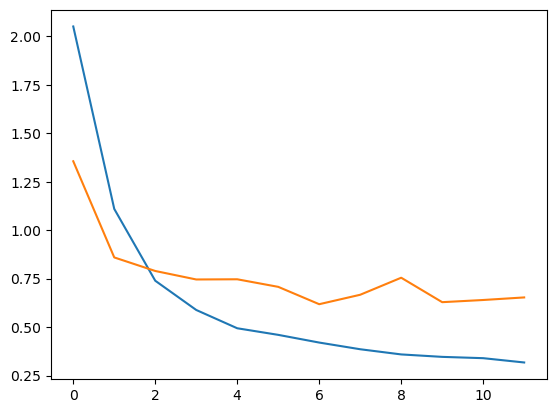

In [41]:
# Define early stopping callback to monitor validation loss and stop if it doesn't improve for 5 epochs
early_stop = EarlyStopping(monitor='val_loss', patience=5)
# Create model
model = LSTM_model(X_train_sc,Y_train_enc)
model.summary()
# Train the model with 200 epochs and batch size of 32, using the early stopping callback
history = model.fit(X_train_sc, Y_train_enc, epochs=200, batch_size=256, validation_data=(X_cv_sc, Y_cv_enc), callbacks=[early_stop])

# Plot the training history for loss and accuracy
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.show()

A classification report is generated showcasing accuracy for different types of faults predicted.

In [42]:
# Define your custom class labels
#custom_labels = ['0', '1', '2', '4', '5', '6', '7', '8', '10', '11', '12', '13', '14', '16', '17', '18', '19','20']

# Obtain predictions and true labels
y_pred = enc.inverse_transform(model.predict(X_test_sc, verbose=0))
y_true = enc.inverse_transform(Y_test_enc)

# Generate classification report
report = classification_report(y_true, y_pred)
print("Classification Report:")
print(report)

# Print accuracy score if needed
print("Bidirectional LSTM integrated with ANN (More Faults) Classification accuracy_score:", accuracy_score(y_true, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.17      0.28      6034
           1       0.96      0.97      0.97      1104
           2       0.97      0.97      0.97      1103
           3       0.22      0.65      0.33      1150
           4       0.94      0.97      0.95       873
           5       0.94      0.98      0.96      1150
           6       0.97      0.98      0.97       918
           7       0.97      0.98      0.98       782
           8       0.88      0.90      0.89       873
           9       0.13      0.21      0.16       943
          10       0.82      0.65      0.72       952
          11       0.48      0.98      0.64       781
          12       0.94      0.90      0.92       989
          13       0.92      0.92      0.92       873
          14       0.98      0.99      0.98       805
          15       0.18      0.31      0.23      1035
          16       0.57      0.70      0.62       988
    